In [1]:
#lets start with some imports

import importlib

#Py-ART, simply the best sowftware around.. Give those guys a grant
import cartopy
import pyart
#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop

import operator

import xarray as xr
import netCDF4

import scipy.ndimage as ndimage

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from cmac import cmac, quicklooks, get_sounding_times, get_sounding_file_name, config, cmac_processing
import copy
import matplotlib.colors as mc
import matplotlib.ticker as mt
import matplotlib.font_manager as fm
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/anaconda3/envs/cmac2/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/scollis/anaconda3/envs/cmac2/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
def _fix_rain_above_bb(gid_fld, rain_class, melt_class, snow_class):
    print(snow_class)
    new_gid = copy.deepcopy(gid_fld)
    for ray_num in range(new_gid['data'].shape[0]):
        if melt_class in new_gid['data'][ray_num, :]:
            max_loc = np.where(
                new_gid['data'][ray_num, :] == melt_class)[0].max()
            rain_above_locs = np.where(
                new_gid['data'][ray_num, max_loc:] == rain_class)[0] + max_loc
            new_gid['data'][ray_num, rain_above_locs] = snow_class
    return new_gid


def do_my_fuzz_csapr2(radar, rhv_field, ncp_field,
               tex_start=2.0, tex_end=2.1, verbose=True):
    if verbose:
        print('##')
        print('## CMAC calculation using fuzzy logic:')

    second_trip = {'velocity_texture': [[tex_start, tex_end, 130., 130.], 4.0],
                   rhv_field: [[.5, .7, 1, 1], 0.0],
                   ncp_field: [[0, 0, .5, .6], 1.0],
                   'height': [[0, 0, 5000, 8000], 0.0],
                   'sounding_temperature': [[-100, -100, 100, 100], 0.0],
                   'signal_to_noise_ratio': [[8, 15, 1000, 1000], 1.0]}

    rain = {'velocity_texture': [[0, 0, tex_start, tex_end], 1.0],
            rhv_field: [[0.97, 0.98, 1, 1], 1.0],
            ncp_field: [[0.4, 0.5, 1, 1], 1.0],
            'height': [[0, 0, 5000, 6000], 0.0],
            'sounding_temperature': [[2., 5., 100, 100], 2.0],
            'signal_to_noise_ratio': [[8, 10, 1000, 1000], 1.0]}

    snow = {'velocity_texture': [[0, 0, tex_start, tex_end], 1.0],
            rhv_field: [[0.65, 0.9, 1, 1], 1.0],
            ncp_field: [[0.4, 0.5, 1, 1], 1.0],
            'height': [[0, 0, 25000, 25000], 0.0],
            'sounding_temperature': [[-100, -100, .5, 4.], 2.0],
            'signal_to_noise_ratio': [[8, 10, 1000, 1000], 1.0]}

    no_scatter = {'velocity_texture': [[tex_start, tex_end, 330., 330.], 2.0],
                  rhv_field: [[0, 0, 0.1, 0.2], 0.0],
                  ncp_field: [[0, 0, 0.1, 0.2], 0.0],
                  'height': [[0, 0, 25000, 25000], 0.0],
                  'sounding_temperature': [[-100, -100, 100, 100], 0.0],
                  'signal_to_noise_ratio': [[-100, -100, 8, 15], 4.0]}

    melting = {'velocity_texture': [[0, 0, tex_start, tex_end], 0.0],
               rhv_field: [[0.6, 0.65, .9, .96], 2.0],
               ncp_field: [[0.4, 0.5, 1, 1], 0],
               'height': [[0, 0, 25000, 25000], 0.0],
               'sounding_temperature': [[0, 0.1, 2, 4], 4.0],
               'signal_to_noise_ratio': [[8, 10, 1000, 1000], 0.0]}

    mbfs = {'multi_trip': second_trip, 'rain': rain, 'snow': snow,
            'no_scatter': no_scatter, 'melting': melting}

    hard_const = [['melting', 'sounding_temperature', (10, 100)],
                  ['multi_trip', 'height', (10000, 1000000)],
                  ['melting', 'sounding_temperature', (-10000, -2)],
                  ['rain', 'sounding_temperature', (-1000, -5)],
                  ['melting', 'velocity_texture', (3, 300)]]

    gid_fld, cats = cmac_processing.cum_score_fuzzy_logic(radar, mbfs=mbfs, verbose=verbose,
                                          hard_const=hard_const)
    rain_val = list(cats).index('rain')
    snow_val = list(cats).index('snow')
    melt_val = list(cats).index('melting')
    return _fix_rain_above_bb(gid_fld, rain_val, melt_val, snow_val), cats


In [3]:
verbose = True
sweep = 2

In [4]:
soundings_directory = '/data/CACTI/sonde/'
radar_directory = '/data/CACTI/csapr2/'


In [5]:
inf = 'corcsapr2cfrppiM1.a1.20181105.190003.nc'
inf2 = 'corcsapr2cfrppiM1.a1.20181105.191503.nc'
radar = pyart.io.read(radar_directory + inf)


In [6]:
ncf_sounding = netCDF4.Dataset(soundings_directory + 'corsondewnpnM1.b1.20181105.180000.cdf')

In [7]:
meta_config = config.get_metadata('cacti_csapr2_ppi')
cmac_config = config.get_cmac_values('cacti_csapr2_ppi')
field_config = config.get_field_names('cacti_csapr2_ppi')
field_config['reflectivity'] = 'uncorrected_reflectivity_h'
field_config['phidp'] = 'uncorrected_differential_phase'

ref_offset = cmac_config['ref_offset']
self_const = cmac_config['self_const']


cmac_config['c_coef'] = 0.3
cmac_config['attenuation_a_coef'] = 0.08
cmac_config['d_coef'] = 1.0804
cmac_config['beta_coef'] = 0.64884

field_config['differential_reflectivity'] = 'differential_reflectivity'
cmac_config['zdr_offset'] = 0.0

In [8]:
radar.fields['differential_phase']['data'] = radar.fields['differential_phase']['data']*-1.0
radar.fields['uncorrected_differential_phase']['data'] = radar.fields['uncorrected_differential_phase']['data']*-1.0

radar.fields['differential_reflectivity']['data'] = radar.fields['differential_reflectivity']['data'] -3.8

In [9]:
radar.fixed_angle

{'long_name': 'Ray target fixed angle',
 'units': 'degree',
 '_FillValue': -9999.0,
 'data': masked_array(data=[ 0.49987793,  1.4996338 ,  2.5982666 ,  3.8012695 ,
                     5.0976562 ,  6.498413  ,  7.998047  ,  9.602051  ,
                    11.299438  , 13.200073  , 15.501709  , 18.4021    ,
                    22.098999  , 26.900024  , 32.700806  ],
              mask=False,
        fill_value=1e+20,
             dtype=float32)}

In [10]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [11]:
rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]


#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('America/Cordoba')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = '%.1f' % radar.fixed_angle['data'][sweep] + ' Degree sweep ' +local_time.strftime('%A %B %d at %I:%M %p GMT%Z')
print(fancy_date_string)

2.6 Degree sweep Monday November 05 at 04:00 PM GMT-03


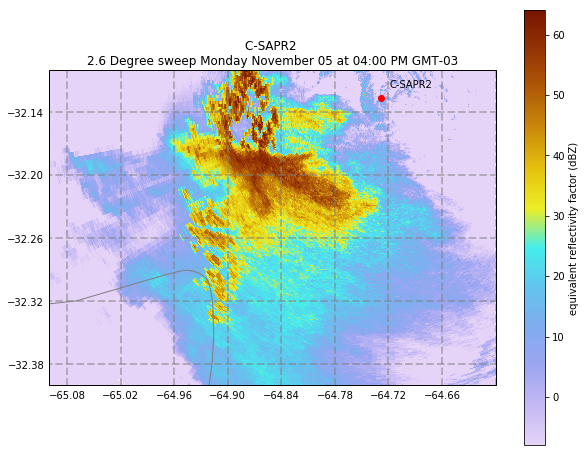

In [12]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'uncorrected_reflectivity_h', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [89]:
print(radar.fields['reflectivity'])

{'long_name': 'Equivalent reflectivity factor', 'units': 'dBZ', 'coordinates': 'elevation azimuth range', 'standard_name': 'equivalent_reflectivity_factor', '_FillValue': -32767, 'data': masked_array(
  data=[[-2.997612476348877, 11.418190002441406, 4.697375297546387, ...,
         -3.7710471153259277, -2.6965041160583496, -6.532189846038818],
        [3.1288576126098633, -4.211885452270508, 17.517107009887695, ...,
         -4.70979642868042, -2.1592326164245605, -4.237469673156738],
        [-3.200319290161133, 11.046232223510742, 18.217723846435547, ...,
         -3.2672319412231445, -4.806229591369629, -6.258634090423584],
        ...,
        [-1.7262663841247559, -4.0977396965026855, -6.059863090515137,
         ..., -9.413381576538086, -14.549934387207031,
         -13.39273452758789],
        [-1.3051085472106934, -8.876110076904297, -13.607248306274414,
         ..., -12.698020935058594, --, --],
        [-0.8327819108963013, -3.2731361389160156, -6.856914520263672,
         .

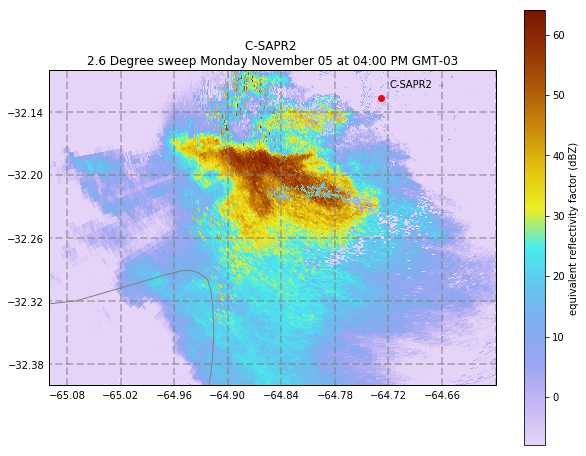

In [88]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [13]:
#This is a cludge to get the clutter field from the file
new_grid = radar.fields['reflectivity']['data'] - radar.fields['uncorrected_reflectivity_h']['data']
clutter = np.zeros(new_grid.shape, dtype=np.int)
possible_contamination = new_grid < -12.0
clutter[possible_contamination] = 1

z = radar.gate_altitude['data']
clutter[(z - z.min()) > 2000. ] = 0


In [14]:
clutter_field = {'data' : clutter,
                'standard_name' : 'clutter_mask',
                'long_name' : 'Clutter mask',
                'comment' : '0 is good, 1 is clutter',
                'valid_min' : 0,
                'valid_max' : 1,
                'units' : 'unitless'}
radar.add_field('clutter', clutter_field, replace_existing=True)

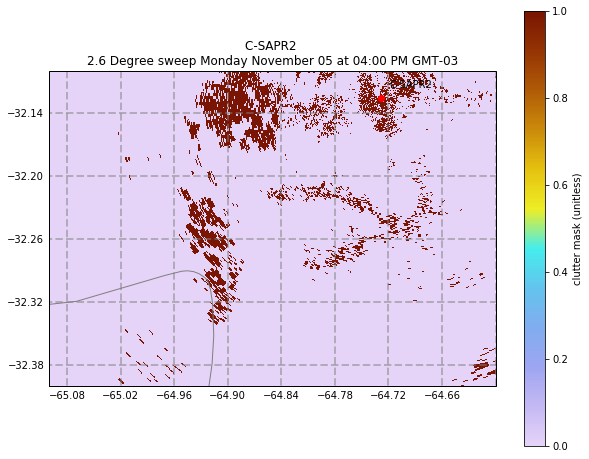

In [15]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'clutter', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=1, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [16]:
radar.fields.keys()


dict_keys(['attenuation_corrected_differential_reflectivity', 'attenuation_corrected_differential_reflectivity_lag_1', 'attenuation_corrected_reflectivity_h', 'censor_mask', 'classification_mask', 'copol_correlation_coeff', 'differential_phase', 'differential_reflectivity', 'differential_reflectivity_lag_1', 'mean_doppler_velocity', 'mean_doppler_velocity_v', 'normalized_coherent_power', 'normalized_coherent_power_v', 'reflectivity', 'reflectivity_v', 'signal_to_noise_ratio_copolar_h', 'signal_to_noise_ratio_copolar_v', 'specific_differential_phase', 'spectral_width', 'spectral_width_v', 'uncorrected_copol_correlation_coeff', 'uncorrected_differential_phase', 'uncorrected_differential_reflectivity', 'uncorrected_differential_reflectivity_lag_1', 'uncorrected_mean_doppler_velocity_h', 'uncorrected_mean_doppler_velocity_v', 'uncorrected_reflectivity_h', 'uncorrected_reflectivity_v', 'uncorrected_spectral_width_h', 'uncorrected_spectral_width_v', 'unthresholded_power_copolar_h', 'unthresh

In [17]:
radar_start_date = netCDF4.num2date(radar.time['data'][0], radar.time['units'])
print('##', str(radar_start_date))

## 2018-11-05 19:00:03


In [18]:
temp_field = field_config['temperature']
alt_field = field_config['altitude']
vel_field = field_config['velocity']

In [19]:
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(ncf_sounding.variables[temp_field][:], 
                                                        ncf_sounding.variables[alt_field][:], 
                                                        radar)


masked_vr = copy.deepcopy(radar.fields[vel_field])
masked_vr['data'] = np.ma.masked_where(radar.fields['clutter']['data'] == 1, masked_vr['data'])
masked_vr['data'][radar.fields['clutter']['data'] == 1] = np.nan
radar.add_field('clutter_masked_velocity', masked_vr, replace_existing=True)

texture =  cmac_processing.get_texture(radar, 'clutter_masked_velocity')
texture['data'][np.isnan(texture['data'])] = 0.0
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)

In [20]:
radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
radar.add_field('height', z_dict, replace_existing=True)
radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)
radar.add_field('velocity_texture', texture, replace_existing=True)


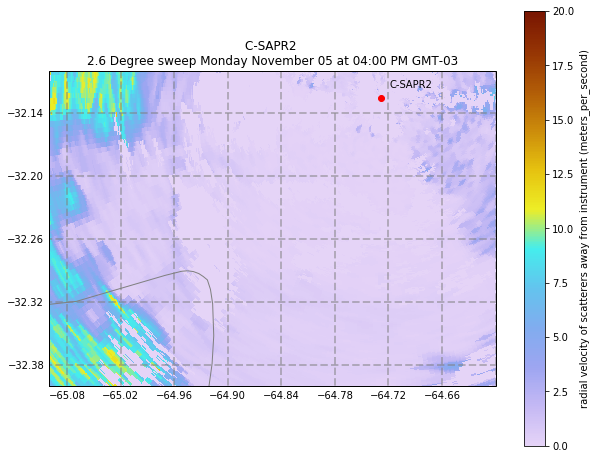

In [21]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'velocity_texture', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=20, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


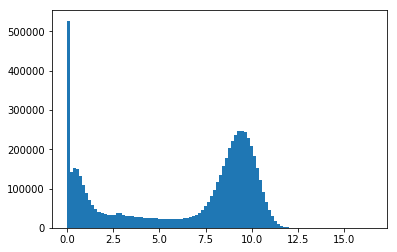

In [22]:
hh = plt.hist(radar.fields['velocity_texture']['data'].flatten(), bins=100)

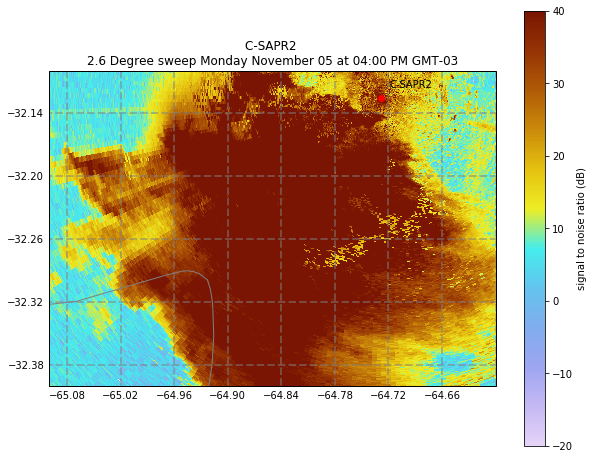

In [23]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'signal_to_noise_ratio', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-20, vmax=40, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

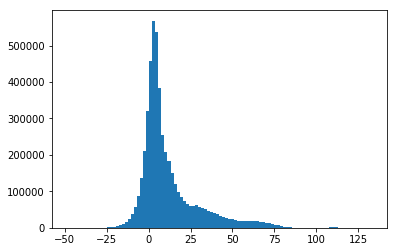

In [24]:
hh = plt.hist(radar.fields['signal_to_noise_ratio']['data'].flatten(), bins=100)

In [25]:
rhv_field = field_config['cross_correlation_ratio']
ncp_field = field_config['normalized_coherent_power']
my_fuzz, _ = do_my_fuzz_csapr2(radar, rhv_field, ncp_field, tex_start=4.,
                        tex_end=5., verbose=True)

radar.add_field('gate_id', my_fuzz,
                replace_existing=True)

##
## CMAC calculation using fuzzy logic:
##    Doing multi_trip
##    Doing rain
##    Doing snow
##    Doing no_scatter
##    Doing melting
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 5404, 5404, 5404]), array([ 0,  1,  2, ..., 30, 31, 32]))
##    Doing hard constraining multi_trip
##     (array([1441, 1441, 1441, ..., 5404, 5404, 5404]), array([1023, 1024, 1025, ..., 1097, 1098, 1099]))
##    Doing hard constraining melting
##     (array([ 381,  382,  382, ..., 5404, 5404, 5404]), array([1099, 1093, 1094, ..., 1097, 1098, 1099]))
##    Doing hard constraining rain
##     (array([ 721,  721,  721, ..., 5404, 5404, 5404]), array([881, 882, 883, ..., 433, 434, 435]))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 5404, 5404, 5404]), array([  75,  220,  221, ..., 1097, 1098, 1099]))
2


In [26]:
radar.fields['gate_id']['data'][clutter == 1] = 5

In [27]:
notes = radar.fields['gate_id']['notes']
radar.fields['gate_id']['notes'] = notes + ',5:clutter'

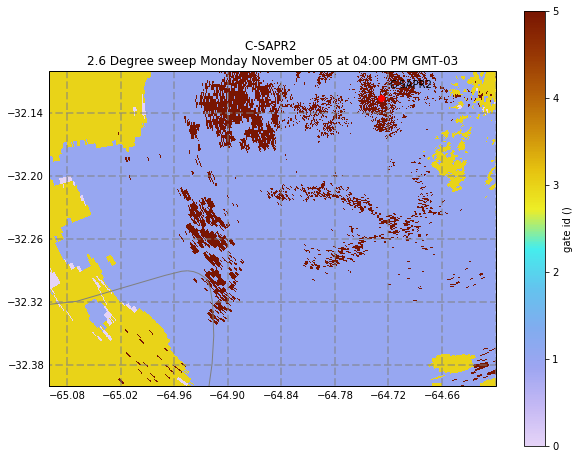

In [28]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'gate_id', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

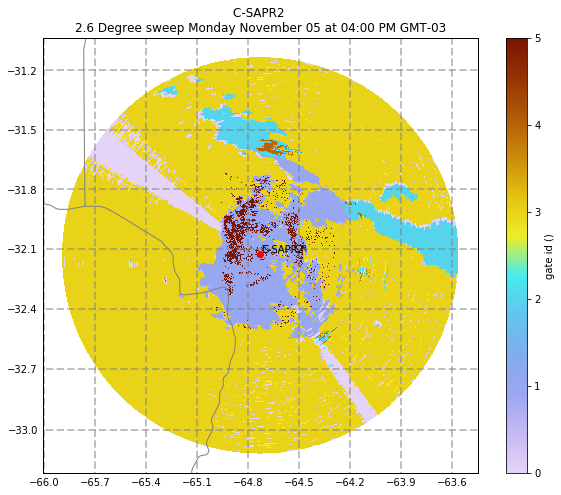

In [29]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'gate_id', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

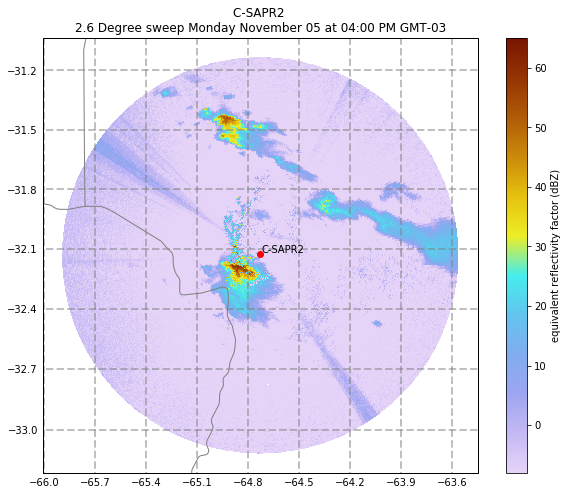

In [30]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=65)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [31]:
print(radar.fields['gate_id']['notes'])

0:multi_trip,1:rain,2:snow,3:no_scatter,4:melting,5:clutter


In [32]:
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})


In [33]:
cmac_gates = pyart.correct.GateFilter(radar)
cmac_gates.exclude_all()
cmac_gates.include_equal('gate_id', cat_dict['rain'])
cmac_gates.include_equal('gate_id', cat_dict['melting'])
cmac_gates.include_equal('gate_id', cat_dict['snow'])


In [34]:
radar.gate_altitude['data']

masked_array(
  data=[[ 1141.,  1141.,  1142., ...,  2333.,  2334.,  2336.],
        [ 1141.,  1141.,  1142., ...,  2354.,  2355.,  2357.],
        [ 1141.,  1141.,  1142., ...,  2375.,  2376.,  2378.],
        ...,
        [ 1141.,  1194.,  1249., ..., 60931., 60985., 61041.],
        [ 1141.,  1194.,  1249., ..., 60931., 60985., 61041.],
        [ 1141.,  1194.,  1249., ..., 60931., 60985., 61041.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [35]:
#Bug: need to fix
radar.gate_altitude['data'] = radar.gate_altitude['data'].data

# Create a simulated velocity field from the sonde object.
u_field = field_config['u_wind']
v_field = field_config['v_wind']
u_wind = ncf_sounding.variables[u_field][:]
v_wind = ncf_sounding.variables[v_field][:]
alt_field = field_config['altitude']
sonde_alt = ncf_sounding.variables[alt_field][:]
profile = pyart.core.HorizontalWindProfile.from_u_and_v(
    sonde_alt, u_wind, v_wind)
sim_vel = pyart.util.simulated_vel_from_profile(radar, profile)
radar.add_field('simulated_velocity', sim_vel, replace_existing=True)


In [36]:
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field=vel_field, ref_vel_field='simulated_velocity',
    keep_original=False, gatefilter=cmac_gates, centered=True)

radar.add_field('corrected_velocity', corr_vel, replace_existing=True)

print('##    corrected_velocity')
print('##    simulated_velocity')

fzl = cmac_processing.get_melt(radar)


##    corrected_velocity
##    simulated_velocity
3966.5


In [37]:

# Calculating differential phase fields.
phidp, kdp = pyart.correct.phase_proc_lp_gf(
    radar, gatefilter=cmac_gates, offset=ref_offset, debug=True,
    nowrap=50, fzl=fzl, self_const=self_const, phidp_field=field_config['phidp'])
phidp_filt, kdp_filt = cmac_processing.fix_phase_fields(
    copy.deepcopy(kdp), copy.deepcopy(phidp), radar.range['data'],
    cmac_gates)

radar.add_field('corrected_differential_phase', phidp,
                replace_existing=True)
radar.add_field('filtered_corrected_differential_phase', phidp_filt,
                replace_existing=True)
radar.add_field('corrected_specific_diff_phase', kdp,
                replace_existing=True)
radar.add_field('filtered_corrected_specific_diff_phase', kdp_filt,
                replace_existing=True)

print('##    corrected_specific_diff_phase')
print('##    filtered_corrected_specific_diff_phase')
print('##    corrected_differential_phase')
print('##    filtered_corrected_differential_phase')


Unfolding
Exec time:  4.750494956970215
Doing  0
Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing  10
Doing  11
Doing  12
Doing  13
Doing  14
(5405, 1099)
(5405, 1100)
##    corrected_specific_diff_phase
##    filtered_corrected_specific_diff_phase
##    corrected_differential_phase
##    filtered_corrected_differential_phase


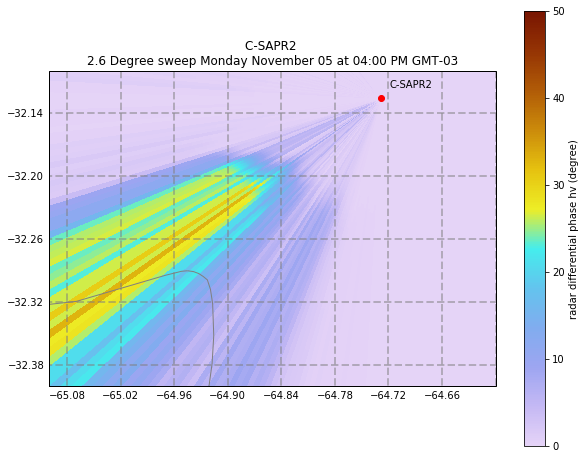

In [38]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'filtered_corrected_differential_phase', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=50, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [39]:
# Calculating attenuation by using pyart.
refl_field = field_config['reflectivity']
attenuation_a_coef = cmac_config['attenuation_a_coef']
c_coef = cmac_config['c_coef']
d_coef = cmac_config['d_coef']
beta_coef = cmac_config['beta_coef']
zdr_field = field_config['differential_reflectivity']

In [40]:
radar.fields['corrected_differential_reflectivity'] = copy.deepcopy(
    radar.fields[zdr_field])
radar.fields['corrected_reflectivity'] = copy.deepcopy(
    radar.fields[refl_field])
radar.fields['corrected_reflectivity']['data'] = np.ma.masked_where(
    cmac_gates.gate_excluded,
    radar.fields['corrected_reflectivity']['data'])

# Get specific differential attenuation.
# Need height over 0C isobar.
iso0 = np.ma.mean(radar.fields['height']['data'][
    np.where(np.abs(radar.fields['sounding_temperature']['data']) < 0.1)])
radar.fields['height_over_iso0'] = copy.deepcopy(radar.fields['height'])
radar.fields['height_over_iso0']['data'] -= iso0

In [41]:
(spec_at, pia_dict, cor_z, spec_diff_at,
 pida_dict, cor_zdr) = pyart.correct.calculate_attenuation_zphi(
     radar, temp_field='sounding_temperature',
     iso0_field='height_over_iso0',
     zdr_field='corrected_differential_reflectivity',
     pia_field='path_integrated_attenuation',
     refl_field=field_config['reflectivity'], 
     c=c_coef, d=d_coef,
     a_coef=attenuation_a_coef, beta=beta_coef,
     phidp_field='filtered_corrected_differential_phase')
cor_zdr['data'] += cmac_config['zdr_offset']
radar.add_field('specific_attenuation', spec_at, replace_existing=True)
radar.add_field('path_integrated_attenuation', pia_dict,
                replace_existing=True)
radar.add_field('corrected_reflectivity', cor_z, replace_existing=True)
radar.add_field('specific_differential_attenuation', spec_diff_at,
                replace_existing=True)
radar.add_field('path_integrated_differential_attenuation', pida_dict,
                replace_existing=True)
radar.add_field('corrected_differential_reflectivity', cor_zdr,
                replace_existing=True)


In [42]:
print(attenuation_a_coef, beta_coef,c_coef, d_coef)

0.08 0.64884 0.3 1.0804


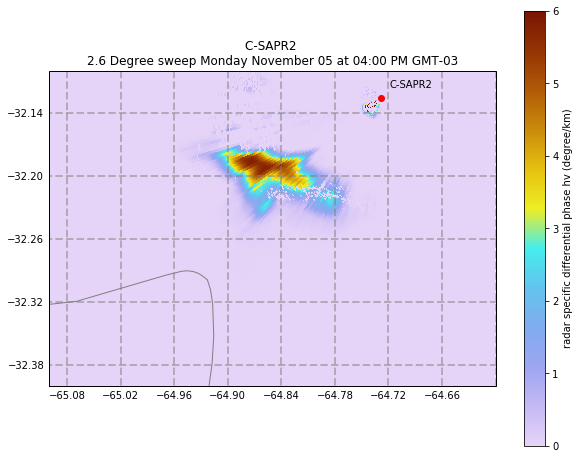

In [43]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'filtered_corrected_specific_diff_phase', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=6, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


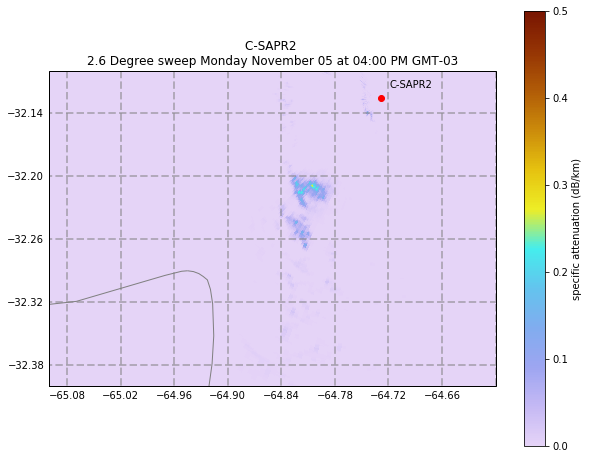

In [44]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'specific_attenuation', 0, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=0.5, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [45]:
# https://journals.ametsoc.org/doi/pdf/10.1175/JAMC-D-13-0321.1

In [46]:
# Calculating rain rate.
R = 294.* (radar.fields['specific_attenuation']['data']) ** 0.89
rainrate = copy.deepcopy(radar.fields['specific_attenuation'])
rainrate['data'] = R
rainrate['valid_min'] = 0.0
rainrate['valid_max'] = 400.0
rainrate['standard_name'] = 'rainfall_rate'
rainrate['long_name'] = 'rainfall_rate'
rainrate['least_significant_digit'] = 1
rainrate['units'] = 'mm/hr'
radar.fields.update({'rain_rate_A': rainrate})

# This needs to be updated to a gatefilter.
mask = radar.fields['reflectivity']['data'].mask

radar.fields['rain_rate_A']['data'][np.where(mask)] = 0.0
radar.fields['rain_rate_A'].update({
    'comment': ('Rain rate calculated from specific_attenuation,',
                ' R=51.3*specific_attenuation**0.81, note R=0.0 where',
                ' norm coherent power < 0.4 or rhohv < 0.8')})

if verbose:
    print('## Rainfall rate as a function of A ##')

print('##')
print('## All CMAC fields have been added to the radar object.')
print('##')

## Rainfall rate as a function of A ##
##
## All CMAC fields have been added to the radar object.
##


In [47]:
clutter = pyart.filters.GateFilter(radar)
clutter.exclude_equal('gate_id', cat_dict['clutter'])


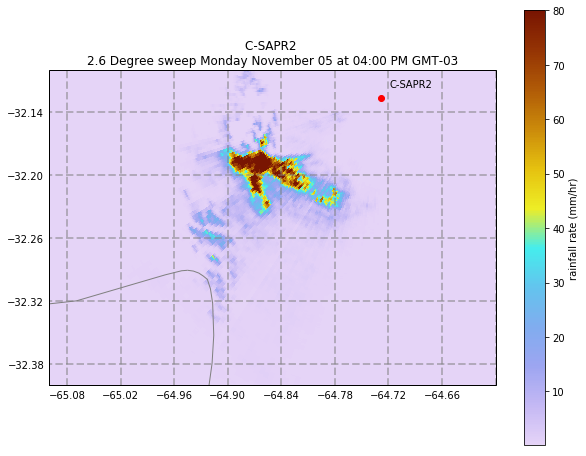

In [48]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_rate_A', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0.1, vmax=80, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


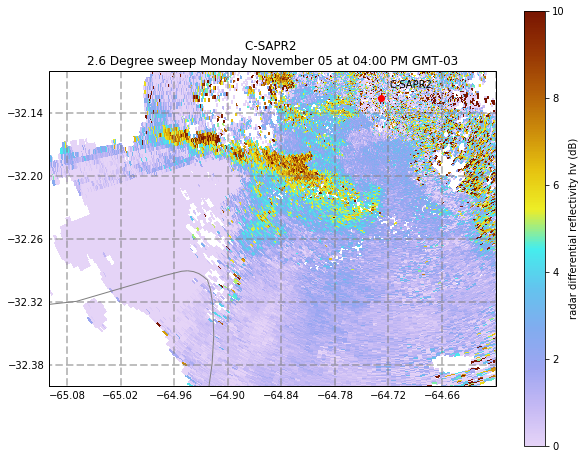

In [49]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=10, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1, gatefilter=cmac_gates)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


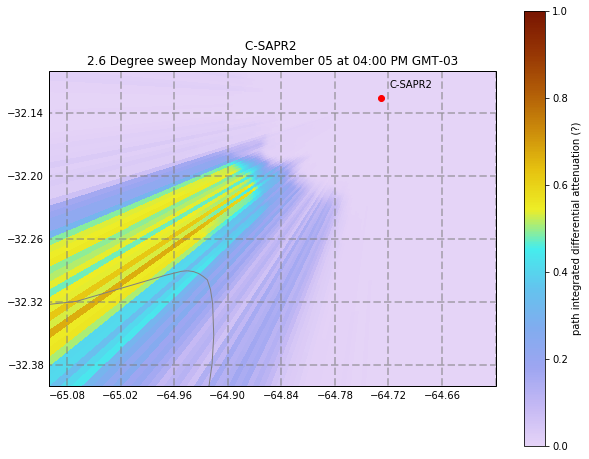

In [50]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'path_integrated_differential_attenuation', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=1, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


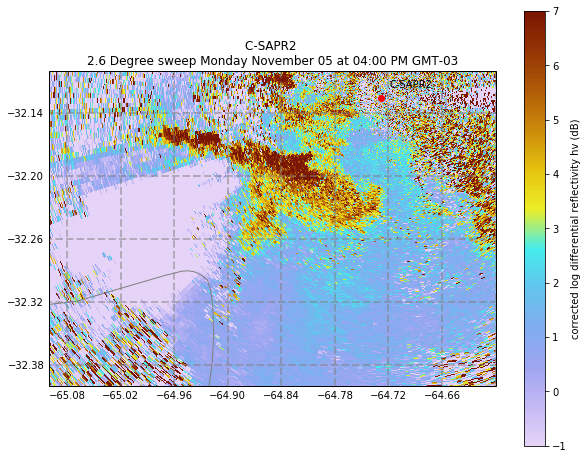

In [51]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-1, vmax=7, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


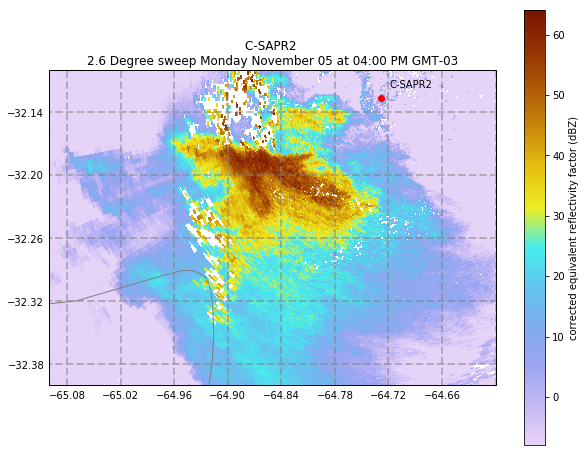

In [52]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter=clutter)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


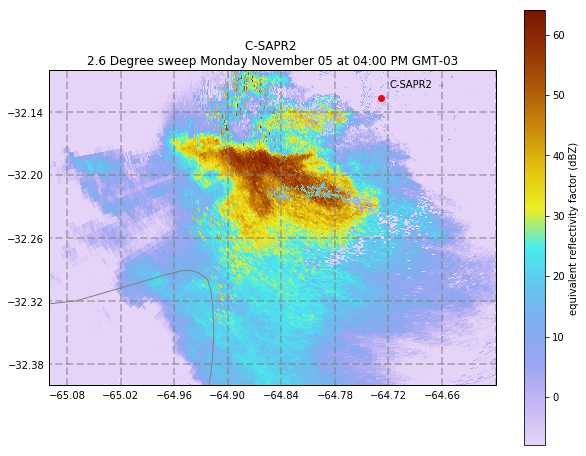

In [53]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


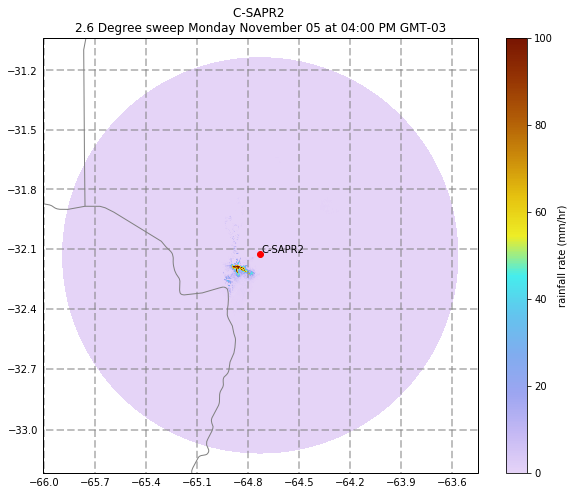

In [54]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_rate_A', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=100 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [55]:
# plot a scale bar with 4 subdivisions on the left side of the map
def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
                   barcol1 = 'white', barcol2='dimgrey'):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(cartopy.crs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = cartopy.crs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = barcol1
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == barcol1:
            barcol = barcol2
        else:
            barcol = barcol1
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col, fontsize=20)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby, str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col, fontsize=20)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    #ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
    #       verticalalignment='bottom', color=col)



##
## Keys for each gate id are as follows:
##    0:multi_trip
##    1:rain
##    2:snow
##    3:no_scatter
##    4:melting
##    5:clutter


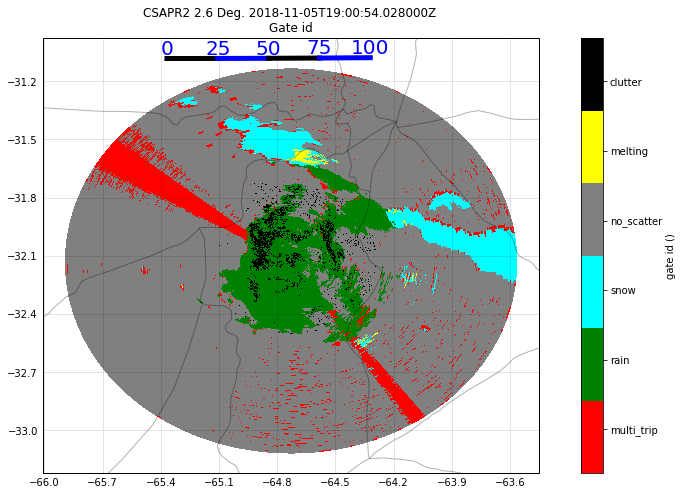

In [56]:
cat_dict = {}
print('##')
print('## Keys for each gate id are as follows:')
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print('##   ', str(pair_str))
    cat_dict.update({pair_str.split(':')[1]:int(pair_str.split(':')[0])})
sorted_cats = sorted(cat_dict.items(), key=operator.itemgetter(1))
cat_colors = {'rain': 'green',
              'multi_trip': 'red',
              'no_scatter': 'gray',
              'snow': 'cyan',
              'melting': 'yellow'}
lab_colors = ['red', 'cyan', 'grey', 'green', 'yellow']

if 'clutter' in radar.fields.keys():
    cat_colors['clutter'] = 'black'
    lab_colors = np.append(lab_colors, 'black')
lab_colors = [cat_colors[kitty[0]] for kitty in sorted_cats]

cmap = mc.ListedColormap(lab_colors)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure( figsize=[15, 8])


display.plot_ppi_map('gate_id', sweep=sweep,
                     cmap=cmap,
                     vmin=0, vmax=5, 
                     projection=cartopy.crs.PlateCarree())

ax = plt.gca()
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=.5, color='black', 
                          alpha=0.3, linestyle='--')

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m'),
              facecolor='none', edgecolor='black', alpha=.3)


scale_bar_left(ax, bars=4,length=100, location=(0.25, 0.98), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


cbax = ax
if 'clutter' in radar.fields.keys():
    tick_locs = np.linspace(
        0, len(sorted_cats) - 2, len(sorted_cats)) + 0.5
else:
    tick_locs = np.linspace(
        0, len(sorted_cats) - 1, len(sorted_cats)) + 0.5
display.cbs[-1].locator = mt.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter = mt.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()

gl.xlabels_top = False
gl.ylabels_right = False




##
## Keys for each gate id are as follows:
##    0:multi_trip
##    1:rain
##    2:snow
##    3:no_scatter
##    4:melting
##    5:clutter


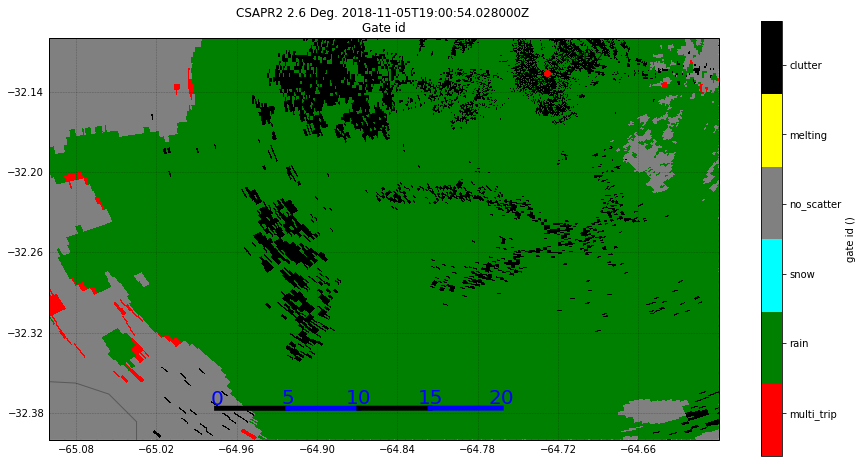

In [57]:
cat_dict = {}
print('##')
print('## Keys for each gate id are as follows:')
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print('##   ', str(pair_str))
    cat_dict.update({pair_str.split(':')[1]:int(pair_str.split(':')[0])})
sorted_cats = sorted(cat_dict.items(), key=operator.itemgetter(1))
cat_colors = {'rain': 'green',
              'multi_trip': 'red',
              'no_scatter': 'gray',
              'snow': 'cyan',
              'melting': 'yellow'}
lab_colors = ['red', 'cyan', 'grey', 'green', 'yellow']

if 'clutter' in radar.fields.keys():
    cat_colors['clutter'] = 'black'
    lab_colors = np.append(lab_colors, 'black')
lab_colors = [cat_colors[kitty[0]] for kitty in sorted_cats]

cmap = mc.ListedColormap(lab_colors)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure( figsize=[15, 8])


display.plot_ppi_map('gate_id', sweep=sweep,
                     cmap=cmap,
                     vmin=0, vmax=5, 
                     projection=cartopy.crs.PlateCarree(), 
                     min_lon=-65.1, min_lat=-32.4, 
                     max_lon=-64.6, max_lat=-32.1)

ax = plt.gca()

gl = display.ax.gridlines(draw_labels=True,
                          linewidth=.5, color='black', 
                          alpha=0.3, linestyle='--')

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m'),
              facecolor='none', edgecolor='black', alpha=.3)


display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


cbax = ax
if 'clutter' in radar.fields.keys():
    tick_locs = np.linspace(
        0, len(sorted_cats) - 2, len(sorted_cats)) + 0.5
else:
    tick_locs = np.linspace(
        0, len(sorted_cats) - 1, len(sorted_cats)) + 0.5
display.cbs[-1].locator = mt.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter = mt.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()

gl.xlabels_top = False
gl.ylabels_right = False




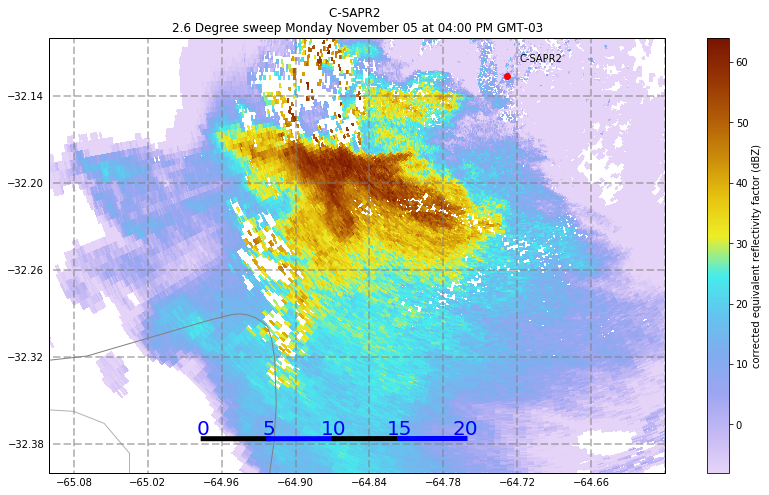

In [58]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter=cmac_gates)

ax = plt.gca()

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m'),
              facecolor='none', edgecolor='black', alpha=.3)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [59]:
cmac_extended = pyart.correct.despeckle.despeckle_field(radar, 'corrected_reflectivity', gatefilter=cmac_gates)

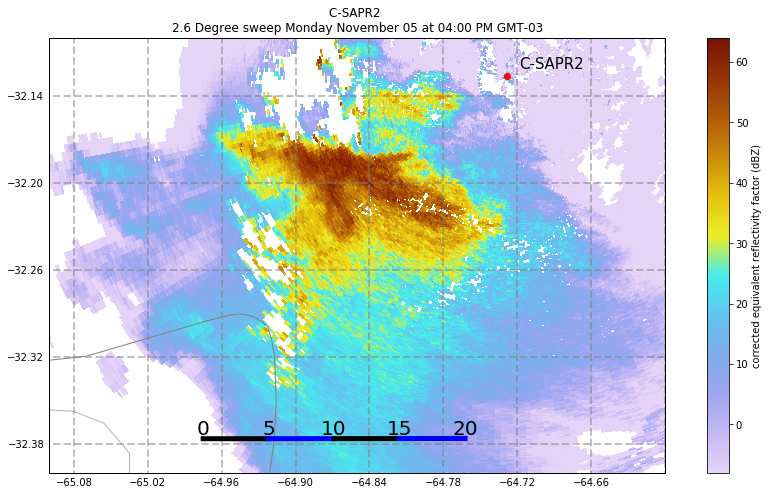

In [60]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter=cmac_extended)

ax = plt.gca()

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m'),
              facecolor='none', edgecolor='black', alpha=.3)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='black', barcol1='black',
              barcol2='blue')


# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [61]:
low_z = cmac_extended.copy()
low_z.exclude_below('reflectivity', -5 )
low_z_desp = pyart.correct.despeckle.despeckle_field(radar, 'corrected_differential_reflectivity',
                                                     gatefilter=low_z)

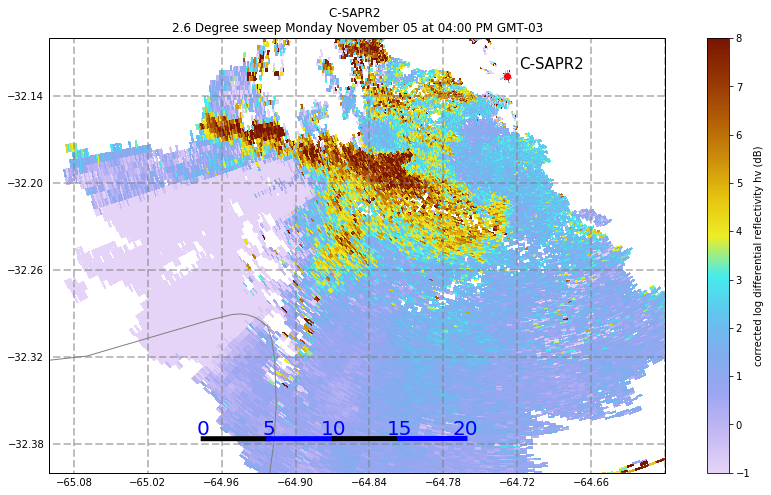

In [62]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-1, vmax=8, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


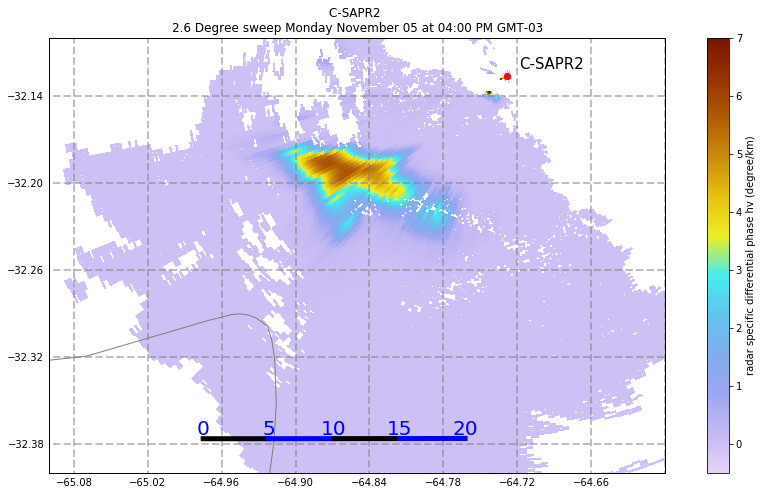

In [63]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'filtered_corrected_specific_diff_phase', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-.5, vmax=7, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


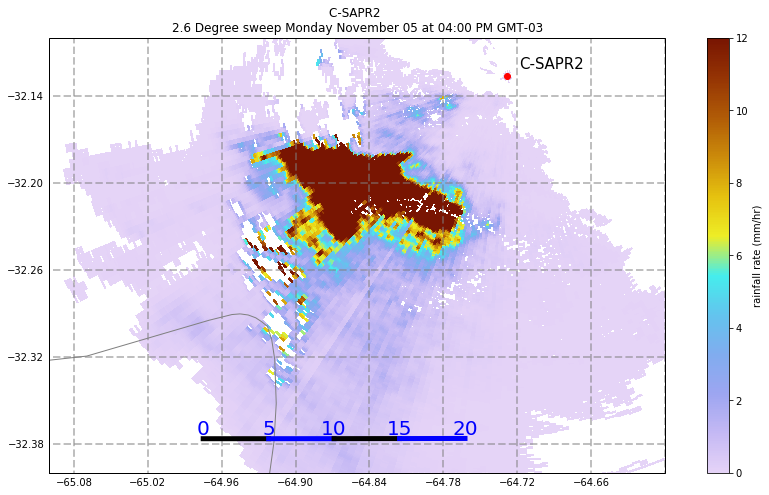

In [64]:
#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_rate_A', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=12, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='blue', barcol1='black',
              barcol2='blue')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [65]:
correct_sweep = radar.get_slice(sweep)
refl_correct_sweep = radar.fields['corrected_reflectivity']['data'][correct_sweep]
correct_lats = radar.gate_latitude['data'][correct_sweep]
correct_lons = radar.gate_longitude['data'][correct_sweep]

refl_correct_sweep_ma = np.ma.masked_where(low_z_desp.gate_excluded[correct_sweep], refl_correct_sweep)
#refl_correct_sweep_ma[low_z_desp.gate_excluded[correct_sweep]] = np.nan

refl_smooth = np.ma.masked_where(low_z_desp.gate_excluded[correct_sweep],
                                 ndimage.gaussian_filter(refl_correct_sweep, sigma=1., order=0))

In [83]:
az_210 = np.where(abs(radar.azimuth['data'] - 210.0) < .5)
first_ray = az_210[0][0]
drdi = radar.range['data'][1] - radar.range['data'][0]
gate_at_30km = 30000./drdi

latline = radar.gate_latitude['data'][int(first_ray), int(gate_at_30km)]
lonline = radar.gate_longitude['data'][int(first_ray), int(gate_at_30km)]


-32.360893

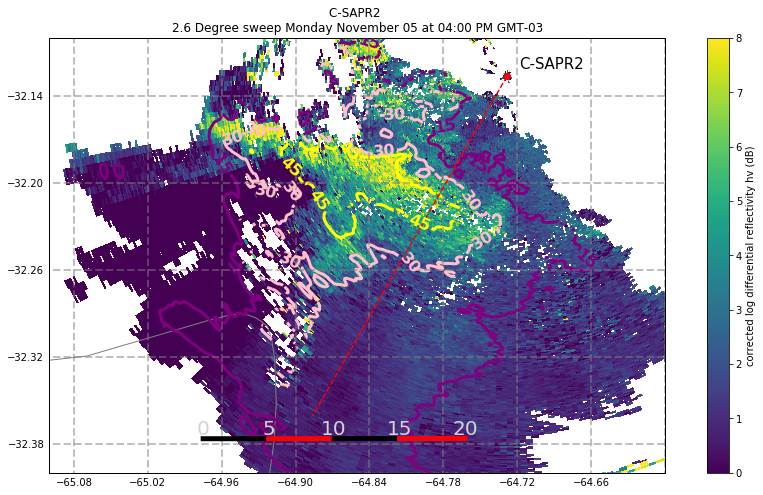

In [87]:
font = fm.FontProperties(weight='bold', size=16)

#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap='viridis',
    vmin=0, vmax=8, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

#ndimage.gaussian_filter(hght_500, sigma=5, order=0)

CS = ax.contour(correct_lons, correct_lats, refl_smooth ,
                levels = [15., 30., 45.],
                transform = cartopy.crs.PlateCarree(), colors=['purple', 'pink', 'yellow'],
                linewidths=3)

labs = ax.clabel(CS, inline=1, fontsize=15,fmt='%1.0f' )
for lab in labs:
    lab.set_font_properties(font)

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.plot([lon_0*-1, lonline], [lat_0, latline], 'r--', transform = cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='lightgrey', barcol1='black',
              barcol2='red')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


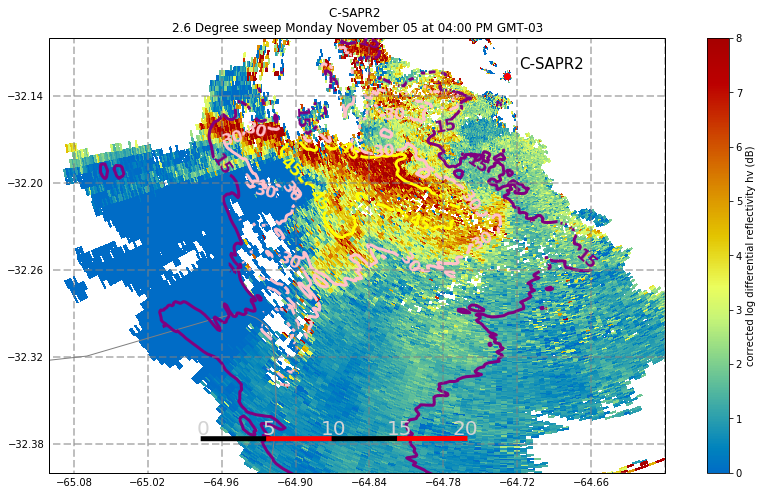

In [67]:
font = fm.FontProperties(weight='bold', size=16)

#Set up our figure
fig = plt.figure( figsize=[15, 8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1.

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'corrected_differential_reflectivity', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
    vmin=0, vmax=8, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1,
    gatefilter = low_z_desp)

ax = plt.gca()

#ndimage.gaussian_filter(hght_500, sigma=5, order=0)

CS = ax.contour(correct_lons, correct_lats, refl_smooth ,
                levels = [15., 30., 45.],
                transform = cartopy.crs.PlateCarree(), colors=['purple', 'pink', 'yellow'],
                linewidths=3)

labs = ax.clabel(CS, inline=1, fontsize=15,fmt='%1.0f' )
for lab in labs:
    lab.set_font_properties(font)

# Mark the radar
display.plot_point(lon_0*-1, lat_0)

x_text, y_text = ax.projection.transform_point(
                lon_0*-1 + .01, lat_0 + .005, cartopy.crs.PlateCarree())

ax.annotate('C-SAPR2', xy=(x_text, y_text), **{'fontsize':15})
    
#ax.text(lon_0*-1., lat_0, "FOO", transform=projection)

scale_bar_left(ax, bars=4,length=20, location=(0.25, 0.08), 
               linewidth=5, col='lightgrey', barcol1='black',
              barcol2='red')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
